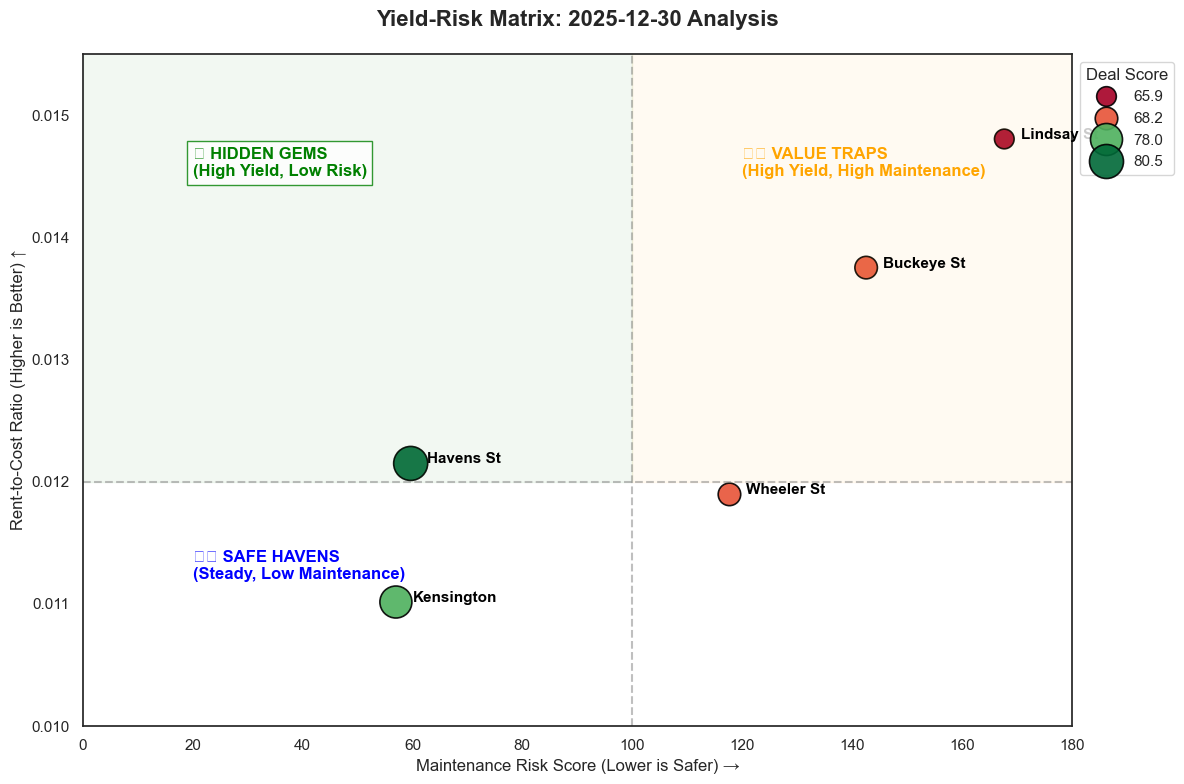

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore') # Clean up output

# 1. Load Data
PROJECT_ROOT = Path("..").resolve()
PREDICTIONS_DIR = PROJECT_ROOT / "data" / "04-predictions"
latest_file = max(list(PREDICTIONS_DIR.glob("*.csv")), key=lambda f: f.stat().st_mtime)
df = pd.read_csv(latest_file)

# 2. Fix the Labels (Get actual street names)
def get_street_name(addr):
    parts = addr.split(" ")
    # If address is "710 N Lindsay St", we want "Lindsay"
    # If "1705 Kensington...", we want "Kensington"
    if len(parts) > 2 and len(parts[1]) <= 2: # heuristic for N, S, E, W
        return f"{parts[2]} {parts[3] if len(parts)>3 else ''}"
    return parts[1]

df['short_label'] = df['addressLine1'].apply(get_street_name)

# 3. Setup Plot
sns.set_theme(style="white") # Cleaner white background
plt.figure(figsize=(12, 8))

# Define Thresholds
RISK_THRESHOLD = 100   # Left is safe, Right is risky
YIELD_THRESHOLD = 0.012 # 1.2% Rule (Above is great, Below is average)

# 4. Create Scatter Plot
scatter = sns.scatterplot(
    data=df,
    x="maintenance_risk_score",
    y="rent_to_cost_ratio",
    hue="deal_score",
    palette="RdYlGn", # Red to Green (Green = High Score)
    size="deal_score",
    sizes=(200, 600), # Make points big and readable
    edgecolor="black",
    alpha=0.9
)

# 5. Draw the "Quadrants" (The Story)
plt.axvline(x=RISK_THRESHOLD, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=YIELD_THRESHOLD, color='gray', linestyle='--', alpha=0.5)

# 6. Add Context Shading & Labels
# Quadrant 1: The Gems (Low Risk, High Yield)
plt.text(x=20, y=0.0145, s="💎 HIDDEN GEMS\n(High Yield, Low Risk)", 
         fontsize=12, color='green', fontweight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='green'))
plt.fill_between(x=[0, RISK_THRESHOLD], y1=YIELD_THRESHOLD, y2=0.016, color='green', alpha=0.05)

# Quadrant 2: Value Traps (High Risk, High Yield)
plt.text(x=120, y=0.0145, s="⚠️ VALUE TRAPS\n(High Yield, High Maintenance)", 
         fontsize=12, color='orange', fontweight='bold')
plt.fill_between(x=[RISK_THRESHOLD, 200], y1=YIELD_THRESHOLD, y2=0.016, color='orange', alpha=0.05)

# Quadrant 3: Safe Havens (Low Risk, Lower Yield)
plt.text(x=20, y=0.0112, s="🛡️ SAFE HAVENS\n(Steady, Low Maintenance)", 
         fontsize=12, color='blue', fontweight='bold')

# 7. Label the Points smartly
for i in range(df.shape[0]):
    # Offset label slightly so it doesn't overlap the dot
    plt.text(
        x=df.maintenance_risk_score[i] + 3, 
        y=df.rent_to_cost_ratio[i], 
        s=df.short_label[i], 
        fontdict=dict(color='black', size=11, weight='bold')
    )

# 8. Final Formatting
plt.title(f"Yield-Risk Matrix: {latest_file.name.split('_')[2]} Analysis", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Maintenance Risk Score (Lower is Safer) →", fontsize=12)
plt.ylabel("Rent-to-Cost Ratio (Higher is Better) ↑", fontsize=12)
plt.xlim(0, 180)
plt.ylim(0.010, 0.0155) # Zoom in to see separation
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title="Deal Score")

plt.tight_layout()
plt.show()